In [1]:
!pip install fastprogress

In [2]:
import os
import string

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.adamw import AdamW

from tqdm import tqdm
tqdm.pandas()

import pandas as pd
import numpy as np

from fastprogress import master_bar, progress_bar

from sklearn.feature_extraction.text import CountVectorizer

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data preprocessing

In [4]:
train_df = pd.read_csv("/content/drive/MyDrive/Colab/ethnicolor/data/census_ln_train.csv")
val_df = pd.read_csv("/content/drive/MyDrive/Colab/ethnicolor/data/census_ln_val.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Colab/ethnicolor/data/census_ln_test.csv")

In [5]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(129802, 3)
(16225, 3)
(16226, 3)


In [6]:
train_df.head()

,name_last,race,race_code
0,Tamashiro,asian,3
1,Pitkin,nh_white,0
2,Gaydos,nh_white,0
3,Ramaglia,nh_white,0
4,Pampinella,nh_white,0


In [7]:
train_df.dropna(inplace=True)
val_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [8]:
train_df.shape

(129801, 3)

## Creating Vocab

In [9]:
vectorizer = CountVectorizer(analyzer='char', lowercase=False)

In [10]:
vectorizer.fit_transform(train_df['name_last'])

<129801x52 sparse matrix of type '<class 'numpy.int64'>'
	with 792054 stored elements in Compressed Sparse Row format>

In [11]:
vocab = list(vectorizer.get_feature_names_out())

In [12]:
n_letters = len(vocab)

# Creating Dataset

In [13]:
race_id_df = train_df[['race', 'race_code']].drop_duplicates().sort_values('race_code')
race_to_id = dict(race_id_df.values)
id_to_race = dict(race_id_df[['race_code', 'race']].values)
all_categories = list(id_to_race.values())
n_categories = len(all_categories)
seq_len = train_df['name_last'].str.len().max()

In [14]:
print(f"classes - {all_categories}")
print(f"no of classes - {n_categories}")
print(f"max seq len - {seq_len}")

classes - ['nh_white', 'nh_black', 'hispanic', 'asian', 'other']
no of classes - 5
max seq len - 15


In [15]:
# helper methods used for transform in dataset

all_letters = ''.join(vocab)
oob = n_letters + 1

def letterToIndex(letter):
    return all_letters.find(letter)

def lineToTensor(line):
    tensor = torch.ones(seq_len) * oob
    for li, letter in enumerate(line):
        tensor[li] = letterToIndex(letter)
    return tensor

In [16]:
lineToTensor('Jason')

tensor([ 9., 26., 44., 40., 39., 53., 53., 53., 53., 53., 53., 53., 53., 53.,
        53.])

In [17]:
print(lineToTensor('Jason').size())

torch.Size([15])


In [18]:
# A custom Dataset class must implement three functions: __init__, __len__, and __getitem__

class EthniColorDataset(Dataset):
  def __init__(self, data_df, transform=None):
    self.df = data_df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    name = self.df.iloc[idx, train_df.columns.get_loc('name_last')]
    if self.transform:
      name = self.transform(name)
    label = self.df.iloc[idx, train_df.columns.get_loc('race_code')]
    #target = getTarget(label)
    target = torch.tensor(label, dtype=torch.int64)
    return name, target

In [19]:
train_dataset = EthniColorDataset(train_df, lineToTensor)
val_dataset = EthniColorDataset(val_df, lineToTensor)
test_dataset = EthniColorDataset(test_df, lineToTensor)

In [20]:
for i in range(3):
  name, label = train_dataset[i]
  print(i, name, label)

0 tensor([19., 26., 38., 26., 44., 33., 34., 43., 40., 53., 53., 53., 53., 53.,
        53.]) tensor(3)
1 tensor([15., 34., 45., 36., 34., 39., 53., 53., 53., 53., 53., 53., 53., 53.,
        53.]) tensor(0)
2 tensor([ 6., 26., 50., 29., 40., 44., 53., 53., 53., 53., 53., 53., 53., 53.,
        53.]) tensor(0)


In [21]:
# The Dataset retrieves our dataset’s features and labels one sample at a time.
# While training a model, we typically want to pass samples in “minibatches”,
# reshuffle the data at every epoch to reduce model overfitting, and
# use Python’s multiprocessing to speed up data retrieval.

batch_size=128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=os.cpu_count())
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=os.cpu_count())

In [22]:
next(iter(train_dataloader))

[tensor([[ 1., 40., 28.,  ..., 53., 53., 53.],
         [ 0., 41., 40.,  ..., 53., 53., 53.],
         [ 5., 43., 34.,  ..., 53., 53., 53.],
         ...,
         [18., 45., 43.,  ..., 53., 53., 53.],
         [12., 26., 43.,  ..., 53., 53., 53.],
         [10., 34., 39.,  ..., 53., 53., 53.]]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 2, 2, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2,
         2, 0, 0, 0, 0, 0, 0, 0])]

In [23]:
for i_batch, sample_batched in enumerate(train_dataloader):
    print(i_batch, sample_batched[0].size(), sample_batched[1].size())
    if i_batch == 2:
        break

0 torch.Size([128, 15]) torch.Size([128])
1 torch.Size([128, 15]) torch.Size([128])
2 torch.Size([128, 15]) torch.Size([128])


In [32]:
# Set the random seed for reproducible results
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # The nn.Embedding layer returns a new tensor with dimension (sequence_length, 1, hidden_size)
        self.embedding = nn.Embedding(input_size, hidden_size)
        # LSTM layer expects a tensor of dimension (batch_size, sequence_length, hidden_size).
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        embedded = self.embedding(input.type(torch.IntTensor).to(input.device))
        # embedded = embedded.view(embedded.shape[0],-1,embedded.shape[3])
        h0 = torch.zeros(self.num_layers, embedded.size(0), self.hidden_size).to(input.device)
        c0 = torch.zeros(self.num_layers, embedded.size(0), self.hidden_size).to(input.device)
        out, _ = self.lstm(embedded, (h0, c0))
        out = out[:, -1, :]  # get the output of the last time step
        out = self.fc(out)
        out = self.softmax(out)
        return out


n_hidden = 256
seq_len = seq_len
vocab_size = n_letters + 1 + 1 # vocab + oob + 1

rnn = LSTM(vocab_size, n_hidden, n_categories, num_layers=2)
rnn.to(device)

LSTM(
  (embedding): Embedding(54, 256)
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [25]:
input = lineToTensor('Rogers')

print(input)
print("input shape : ",input.shape)
print("input shape w batch : ", input.unsqueeze(0).shape)
#print(hidden.shape)

# sending with batch 1
output = rnn(input.unsqueeze(0).to(device))
# print(output) - has 47x8 log values
print(output.shape)
print(output)
print(torch.argmax(output))
print(f"model predicted w/o train - {all_categories[torch.argmax(output).item()]}")

tensor([17., 40., 32., 30., 43., 44., 53., 53., 53., 53., 53., 53., 53., 53.,
        53.])
input shape :  torch.Size([15])
input shape w batch :  torch.Size([1, 15])
torch.Size([1, 5])
tensor([[-1.5884, -1.5540, -1.6188, -1.7310, -1.5649]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)
tensor(1, device='cuda:0')
model predicted w/o train - nh_black


## Training


In [26]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

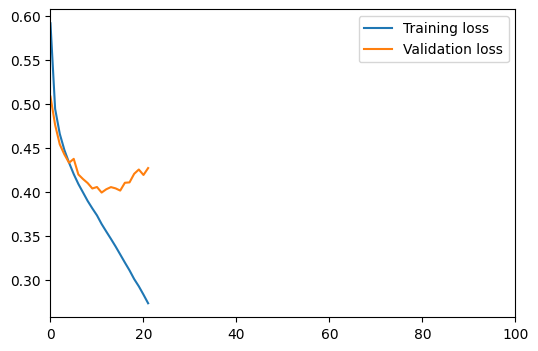

Validation loss decreased (inf --> 0.508184).  Saving model ...
Validation loss decreased (0.508184 --> 0.476013).  Saving model ...
Validation loss decreased (0.476013 --> 0.453885).  Saving model ...
Validation loss decreased (0.453885 --> 0.442305).  Saving model ...
Validation loss decreased (0.442305 --> 0.432980).  Saving model ...
Validation loss decreased (0.432980 --> 0.419682).  Saving model ...
Validation loss decreased (0.419682 --> 0.414480).  Saving model ...
Validation loss decreased (0.414480 --> 0.409937).  Saving model ...
Validation loss decreased (0.409937 --> 0.403769).  Saving model ...
Validation loss decreased (0.403769 --> 0.399147).  Saving model ...


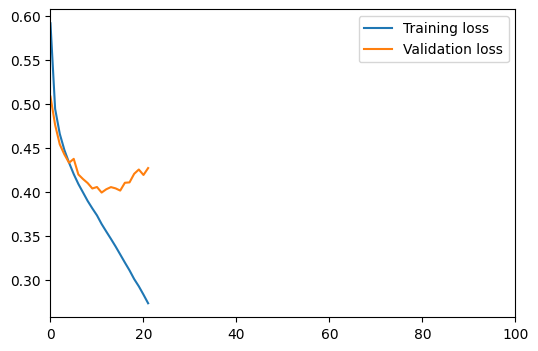

In [33]:
epochs = 100
lr = 0.0001 # 0.005 is very slow


# CrossEntropyLoss expects raw prediction values while NLLLoss expects log probabilities.
# criterion = nn.CrossEntropyLoss() # nn.NLLLoss()
# since we are using nn.LogSoftmax as final layer at model
criterion = nn.NLLLoss()

optimizer = AdamW(rnn.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=60, eta_min=1e-5)


early_stopper = EarlyStopper(patience=10)


mb = master_bar(range(epochs))
mb.names = ['Training loss', 'Validation loss']

x = []
training_losses = []
validation_losses = []

valid_mean_min = np.Inf

till_batch = 1000

for epoch in mb:
  x.append(epoch)
  # Train
  i = 0
  rnn.train()
  total_loss = torch.Tensor([0.0]).to(device)
  for batch in progress_bar(train_dataloader, parent=mb):
    rnn.zero_grad()
    input = batch[0].to(device)
    label = batch[1].to(device)
    output = rnn(input)
    loss = criterion(output, label)
    # backward propagation
    loss.backward()
    # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
    #torch.nn.utils.clip_grad_norm_(rnn.parameters(), clip)
    optimizer.step()
    with torch.no_grad():
      total_loss += loss.item()
    i += 1
    #if i == till_batch:
    #  break

  # decay lr
  scheduler.step()

  mean = total_loss / len(train_dataloader)
  #mean = total_loss / till_batch
  training_losses.append(mean.cpu())

  # Evaluate
  i = 0
  rnn.eval()
  validation_loss = torch.Tensor([0.0]).to(device)
  with torch.no_grad():
    for batch in progress_bar(val_dataloader, parent=mb):
      input = batch[0].to(device)
      label = batch[1].to(device)
      output = rnn(input)
      loss = criterion(output, label)
      validation_loss += loss.item()
      i += 1
      #if i == till_batch:
      #  break

  val_mean = validation_loss / len(val_dataloader)
  #val_mean = validation_loss / till_batch
  validation_losses.append(val_mean.cpu())
  # Update training chart
  mb.update_graph([[x, training_losses], [x, validation_losses]], [0,epochs])
  mb.write(f"\nEpoch {epoch}: Training loss {mean.item():.6f} validation loss {val_mean.item():.6f} with lr {lr:.6f}")
  # save model if validation loss has decreased
  if val_mean.item() <= valid_mean_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_mean_min,
      val_mean.item()))
      torch.save(rnn.state_dict(), '/content/drive/MyDrive/Colab/ethnicolor/census_lstm_lastname.pt')
      valid_mean_min = val_mean.item()

  if early_stopper.early_stop(val_mean.item()):
      break

## Save Model

In [34]:
torch.save(rnn.state_dict(), '/content/drive/MyDrive/Colab/ethnicolor/census_lstm_LastName_after_train.pt')

Text(0, 0.5, 'loss')

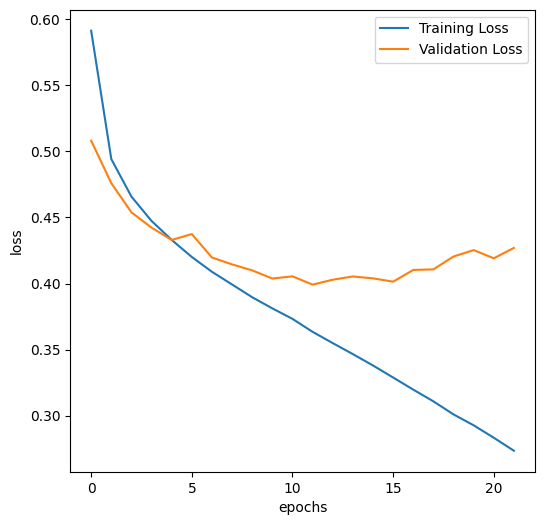

In [35]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(x, training_losses, validation_losses)
ax.legend(['Training Loss', 'Validation Loss'])
plt.xlabel("epochs")
plt.ylabel("loss")

In [36]:
# last epoch losses
print(training_losses[-1])
print(validation_losses[-1])

tensor([0.2734])
tensor([0.4270])


## Testing

In [37]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [38]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# track test loss
test_loss = 0.0


class_correct = list(0. for i in range(n_categories))
class_total = list(0. for i in range(n_categories))


actual = []
predictions = []

rnn.eval()
# iterate over test data
pbar = tqdm(test_dataloader, total=len(test_dataloader), position=0, desc="Testing", leave=True)
for batch in pbar:
    # move tensors to GPU if CUDA is available
    input = batch[0].to(device)
    label = batch[1].to(device)
    output = rnn(input)
    loss = criterion(output, label)
    test_loss += loss.item()
    pred = torch.argmax(output, dim=1)
    correct_tensor = pred.eq(label.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(label.shape[0]):
        l = label.data[i]
        class_correct[l.long()] += correct[i].item()
        class_total[l.long()] += 1
        # for confusion matrix
        actual.append(all_categories[label.data[i].item()])
        predictions.append(all_categories[pred.data[i].item()])


# plot confusion matrix
cm = confusion_matrix(actual, predictions, labels=all_categories)
print(classification_report(actual, predictions))

Testing: 100%|██████████| 126/126 [00:02<00:00, 45.05it/s]


              precision    recall  f1-score   support

       asian       0.60      0.55      0.58       915
    hispanic       0.66      0.61      0.64      1108
    nh_black       0.40      0.09      0.15       782
    nh_white       0.90      0.96      0.93     13242
       other       0.58      0.09      0.15        81

    accuracy                           0.87     16128
   macro avg       0.63      0.46      0.49     16128
weighted avg       0.84      0.87      0.85     16128



In [39]:
test_loss/len(test_dataloader)

0.4383845142428837

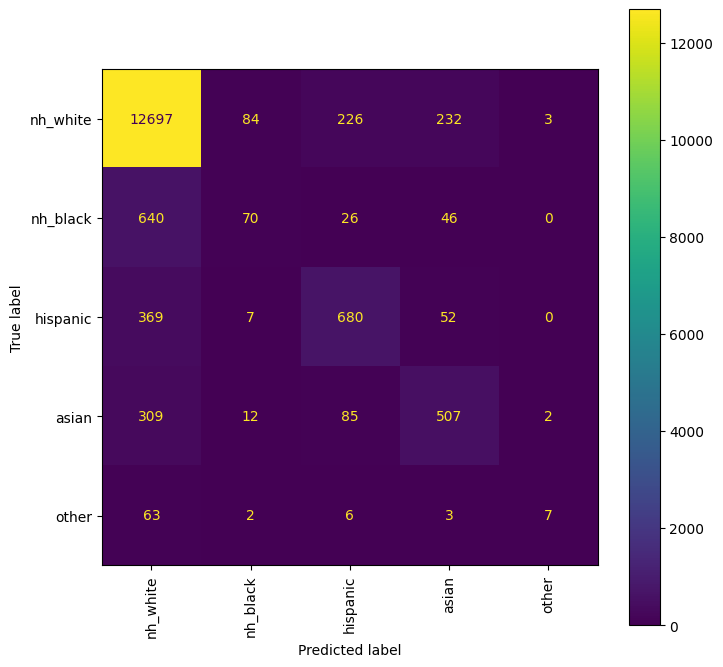

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

cmp = ConfusionMatrixDisplay(cm, display_labels=all_categories)
fig, ax = plt.subplots(figsize=(8,8))
cmp.plot(ax=ax, xticks_rotation='vertical')

In [41]:
# average test loss
test_loss = test_loss/len(test_dataloader)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(all_categories)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            all_categories[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (all_categories[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.438385

Test Accuracy of nh_white: 95% (12697/13242)
Test Accuracy of nh_black:  8% (70/782)
Test Accuracy of hispanic: 61% (680/1108)
Test Accuracy of asian: 55% (507/915)
Test Accuracy of other:  8% ( 7/81)

Test Accuracy (Overall): 86% (13961/16128)


## Inference

In [42]:
name = "Perez"
name_tokens = lineToTensor(name)
inp = name_tokens
print(inp.shape)
out = rnn(inp.unsqueeze(0).to(device))
print(out.shape)
out = torch.argmax(out)
print(out)
print(all_categories[out.item()])

torch.Size([15])
torch.Size([1, 5])
tensor(2, device='cuda:0')
hispanic


## Load and Test

In [43]:
test_rnn = LSTM(vocab_size, n_hidden, n_categories, num_layers=2)
test_rnn.load_state_dict(torch.load('/content/drive/MyDrive/Colab/ethnicolor/census_lstm_lastname.pt'))
test_rnn.to(device)

LSTM(
  (embedding): Embedding(54, 256)
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)

Testing: 100%|██████████| 126/126 [00:02<00:00, 45.07it/s]


              precision    recall  f1-score   support

       asian       0.72      0.43      0.54       919
    hispanic       0.69      0.56      0.62      1105
    nh_black       0.49      0.04      0.08       780
    nh_white       0.89      0.98      0.93     13243
       other       0.33      0.01      0.02        81

    accuracy                           0.87     16128
   macro avg       0.63      0.40      0.44     16128
weighted avg       0.84      0.87      0.84     16128

Test Loss: 0.409712

Test Accuracy of nh_white: 97% (12954/13243)
Test Accuracy of nh_black:  4% (35/780)
Test Accuracy of hispanic: 55% (614/1105)
Test Accuracy of asian: 43% (397/919)
Test Accuracy of other:  1% ( 1/81)

Test Accuracy (Overall): 86% (14001/16128)


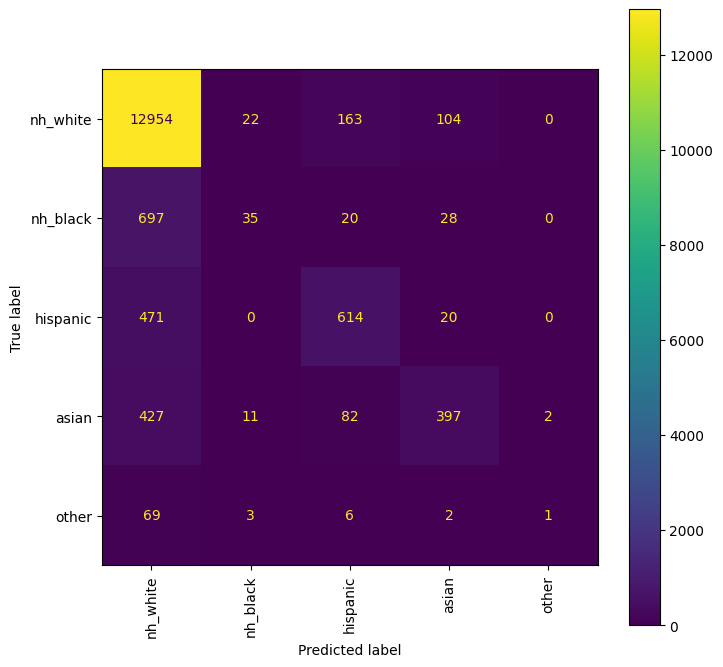

In [44]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# track test loss
test_loss = 0.0


class_correct = list(0. for i in range(n_categories))
class_total = list(0. for i in range(n_categories))


actual = []
predictions = []

rnn.eval()
# iterate over test data
pbar = tqdm(test_dataloader, total=len(test_dataloader), position=0, desc="Testing", leave=True)
for batch in pbar:
    # move tensors to GPU if CUDA is available
    input = batch[0].to(device)
    label = batch[1].to(device)
    output = test_rnn(input)
    loss = criterion(output, label)
    test_loss += loss.item()
    pred = torch.argmax(output, dim=1)
    correct_tensor = pred.eq(label.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(label.shape[0]):
        l = label.data[i]
        class_correct[l.long()] += correct[i].item()
        class_total[l.long()] += 1
        # for confusion matrix
        actual.append(all_categories[label.data[i].item()])
        predictions.append(all_categories[pred.data[i].item()])


# plot confusion matrix
cm = confusion_matrix(actual, predictions, labels=all_categories)
print(classification_report(actual, predictions))

import matplotlib.pyplot as plt
%matplotlib inline

cmp = ConfusionMatrixDisplay(cm, display_labels=all_categories)
fig, ax = plt.subplots(figsize=(8,8))
cmp.plot(ax=ax, xticks_rotation='vertical')

# average test loss
test_loss = test_loss/len(test_dataloader)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(all_categories)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            all_categories[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (all_categories[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

In [ ]:
!du -sh /content/drive/MyDrive/Colab/ethnicolor/lstm_lastname.pt

4.1M	/content/drive/MyDrive/Colab/ethnicolor/lstm_lastname.pt
